# Learning Through the Grapevine 

## Set Up 

A few setup steps. Might take a few minutes the very first time if you don't have the required packages installed. Will take a few seconds after that.

In [1]:
using Pkg
Pkg.activate(".")
Pkg.instantiate()

  Activating project at `D:\Programming\GrapevineModel`


In [2]:
#check if multiple threads are available, it's ok if not
Threads.nthreads()

1

In [3]:
#some modules we might need
using DataFrames, Statistics, LaTeXStrings, GraphIO, GraphPlot, Graphs, PyPlot, SNAPDatasets, StatsBase
using PyPlot: grid as grd # avoid conflict with Graphs.grid
using Revise

In [4]:
includet("GrapevineModel.jl")
using .GrapevineModel

## Testing the Influence Function

In [5]:
s0 = 1
n = 400
n_sources = 6
theta = 0.75
d_test = 10
p = 0.95
mu10 = 0.05
mu01 = 0.15
params = (p, mu10, mu01)

(0.95, 0.05, 0.15)

In [6]:
g = watts_strogatz(n, 4, 0.2)
# g = loadsnap(:facebook_combined)

{400, 800} undirected simple Int64 graph

In [7]:
sources = sample(vertices(g), n_sources; replace=false)
msgs = Dict(sources .=> Int.(ones(n_sources)))
instance = Grapevine(g, sources, msgs, mu10, mu01, p, theta)

Grapevine
  g: SimpleGraph{Int64}
  sources: Array{Int64}((6,)) [371, 118, 240, 24, 268, 22]
  source_msg: Dict{Int64, Int64}
  mu10: Float64 0.05
  mu01: Float64 0.15
  p: Float64 0.95
  theta: Float64 0.75


Without specifying the corrupted set, `influence(instance)` just returns the average learned probability accross the network in the `instance`. 

In [8]:
@time influence(instance, method=:empirical, verbose=false)

  0.638909 seconds (4.53 M allocations: 271.825 MiB, 9.60% gc time, 52.76% compilation time)


0.8339017765313812

`influence(instance, S_corr)` returns the *drop* in average learned probability after corrupting all the sources in $S_{\text{corr}}$.

In [9]:
@time influence(instance, sources[[1, 2]])

method: analytic
Original average learned probability = 0.8342
After corrupting [371, 118], the learned probability drops by  0.0884
Corrupted average learned probability = 0.7458
  6.871094 seconds (76.22 M allocations: 4.760 GiB, 9.60% gc time, 3.15% compilation time)


0.0883976875362481

`influence(instance, S_corr; method=:empirical)` is used to estimate the influence by running simulations rather than analytically.

In [10]:
@time influence(instance; method=:empirical)

method = empirical
Average learned probability = 0.8369
  0.293504 seconds (4.02 M allocations: 244.899 MiB, 14.61% gc time)


0.8369291261777831

In [11]:
@time influence(instance, sources[[1, 2]]; method=:empirical)

method: empirical
Original average learned probability = 0.8333
After corrupting [371, 118], the learned probability drops by  0.0885
Corrupted average learned probability = 0.7447
  0.283407 seconds (4.02 M allocations: 244.903 MiB, 12.92% gc time)


0.08854326872976159

Any other function in GrapevineModel.jl can be called like this: `GrapevineModel.posterior(...)`.

## Testing the Facebook network

Load a facebook network from the SNAP collection. If you want to try constructing a random graph, this should provide a lot of common exmaples: https://juliagraphs.org/Graphs.jl/dev/core_functions/simplegraphs_generators/#Generators-for-common-graphs. 

In [12]:
g = loadsnap(:facebook_combined)

# g = watts_strogatz(1000, 6, 0.3) # example of a random graph

{4039, 88234} undirected simple Int64 graph

Set the parameters for the model.

In [13]:
n = nv(g)

n_sources = 5
theta = 0.6# prior probability the true state is 1
p = 0.8 # dropout rate
mu10 = 0.05 # mutation from 1 to 0
mu01 = 0.1; # mutation from 0 to 1

Randomly choose the sources and their original messages. By default, everyone propagates 1.

In [14]:
# r = 0.001 # probability that any given node is a source
# sources = [x for x in vertices(g) if rand()<r] # assign sources randomly

sources = sample(vertices(g), n_sources; replace=false)
original_msg = Dict(sources .=> ones(Int, length(sources)))

Dict{Int64, Int64} with 5 entries:
  2838 => 1
  2247 => 1
  1474 => 1
  72   => 1
  3824 => 1

Collect the parameters into a type (a collection of properties) called Grapevine. Properties we need to provide:

Property::Type                   |Description
:--------------------------------|:-------------------------------------
g::SimpleGraph{Int64}            |underlying graph                     
sources::Vector{Int64}           |array of sources                     
source_msg::Dict{Int64, Int64}   |original messages by sources         
mu10::Float64                    |probability of mutation from 1 to 0
mu01::Float64                    |probability of mutation from 0 to 1
p::Float64                       |probability of dropping the message
theta::Float64                   |prior probability of agents that ω=1

In [15]:
instance = Grapevine(g, sources, original_msg, mu10, mu01, p, theta)

Grapevine
  g: SimpleGraph{Int64}
  sources: Array{Int64}((5,)) [2247, 1474, 2838, 72, 3824]
  source_msg: Dict{Int64, Int64}
  mu10: Float64 0.05
  mu01: Float64 0.1
  p: Float64 0.8
  theta: Float64 0.6


### Running a single simulation and computing the learned probabilities

Let's run an experiment on our instance. This outputs average learned probability accross the network for each iteration.

In [16]:
N = 100 # number of repetitions
@time data = run_experiment(instance, N);

  3.341505 seconds (50.48 M allocations: 2.921 GiB, 12.18% gc time, 1.71% compilation time)


The data is a dictionary where the key is the number of the experiment and the value is another dictionary which gives the learned probablity for every node.

In [17]:
data

Dict{Any, Any} with 100 entries:
  5  => Dict(2288=>0.951008, 1703=>0.985019, 1956=>0.988294, 2350=>0.309929, 34…
  56 => Dict(2288=>0.306571, 1703=>0.991887, 1956=>0.982061, 2350=>0.880356, 34…
  35 => Dict(2288=>0.980847, 1703=>0.880356, 1956=>0.982061, 2350=>0.912583, 34…
  55 => Dict(2288=>0.951008, 1703=>0.880356, 1956=>0.835551, 2350=>0.951008, 34…
  60 => Dict(2288=>0.937863, 1703=>0.991887, 1956=>0.6, 2350=>0.76715, 3406=>0.…
  30 => Dict(2288=>0.798272, 1703=>0.985019, 1956=>0.76715, 2350=>0.798272, 340…
  32 => Dict(2288=>0.94173, 1703=>0.961426, 1956=>0.951008, 2350=>0.880356, 340…
  6  => Dict(2288=>0.951008, 1703=>0.835551, 1956=>0.835551, 2350=>0.798272, 34…
  67 => Dict(2288=>0.6, 1703=>0.991887, 1956=>0.977083, 2350=>0.991188, 3406=>0…
  45 => Dict(2288=>0.912583, 1703=>0.973042, 1956=>0.145478, 2350=>0.992652, 34…
  73 => Dict(2288=>0.76715, 1703=>0.961426, 1956=>0.961426, 2350=>0.798272, 340…
  64 => Dict(2288=>0.996641, 1703=>0.945086, 1956=>0.365751, 2350=>0.951008,

In [18]:
# compute the average learned probablily for each experiment
data_comb = [mean(values(x)) for x in values(data)] 

100-element Vector{Float64}:
 0.8174667678948271
 0.8231813185795959
 0.8192699750220256
 0.8178702142286718
 0.8241890436133065
 0.8158230856642463
 0.8181438712532594
 0.8218829388399899
 0.8213995395824544
 0.8150839590230214
 0.8206702446289591
 0.8186095079624001
 0.8237183159605951
 ⋮
 0.82077791619113
 0.8211968559931498
 0.8222377461598174
 0.8159993060249737
 0.8210303447032903
 0.8162005984432202
 0.8200991456552179
 0.8213773794401722
 0.823686623333727
 0.8113474985977905
 0.8226316286149342
 0.8255553685978374

Let's see the spread of average probability between iterations, they should be quite close together.

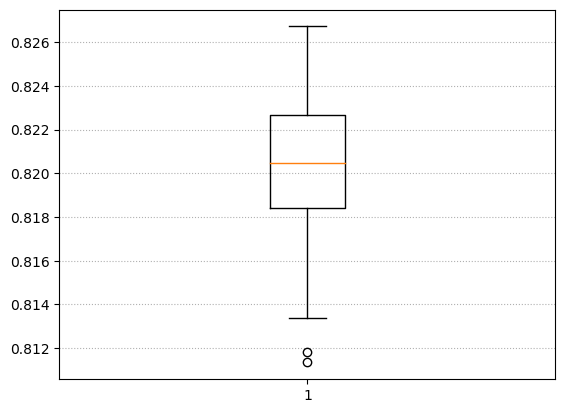

In [19]:
boxplot(data_comb)
grd(axis="y", ls=":")

Now compute the analytic expected learned probability for this instance and compare it to the empirical estimate. Don't try with many (>5) sources!

In [20]:
@time analytic_elp = influence(instance)

method = analytic
Average learned probability = 0.8204
 20.525656 seconds (238.06 M allocations: 14.962 GiB, 9.73% gc time, 0.24% compilation time)


0.8203601623304823

In [21]:
@time empirical_elp = influence(instance; method=:empirical)

method = empirical
Average learned probability = 0.8197
  2.642061 seconds (40.25 M allocations: 2.331 GiB, 11.84% gc time)


0.8196610256928578

In [22]:
diff = (empirical_elp - analytic_elp)/analytic_elp # percentage difference between the empirical and analytic estimates

-0.000852231336585546

### Corrupting the sources

Let's see the  effect of corrupting individual sources.

In [23]:
corrupt_score = Dict(sources .=> zeros(length(sources))) # initialise

Dict{Int64, Float64} with 5 entries:
  2838 => 0.0
  2247 => 0.0
  1474 => 0.0
  72   => 0.0
  3824 => 0.0

In [24]:
for s in sources
    println("Source: $s")
    corrupt_score[s] = influence(instance, [s]; method=:empirical)
    println()
end

Source: 2247
method: empirical
Original average learned probability = 0.8202
After corrupting [2247], the learned probability drops by  0.1109
Corrupted average learned probability = 0.7093

Source: 1474
method: empirical
Original average learned probability = 0.8208
After corrupting [1474], the learned probability drops by  0.1302
Corrupted average learned probability = 0.6906

Source: 2838
method: empirical
Original average learned probability = 0.8212
After corrupting [2838], the learned probability drops by  0.1063
Corrupted average learned probability = 0.7149

Source: 72
method: empirical
Original average learned probability = 0.8203
After corrupting [72], the learned probability drops by  0.0834
Corrupted average learned probability = 0.7369

Source: 3824
method: empirical
Original average learned probability = 0.8201
After corrupting [3824], the learned probability drops by  0.0792
Corrupted average learned probability = 0.7408



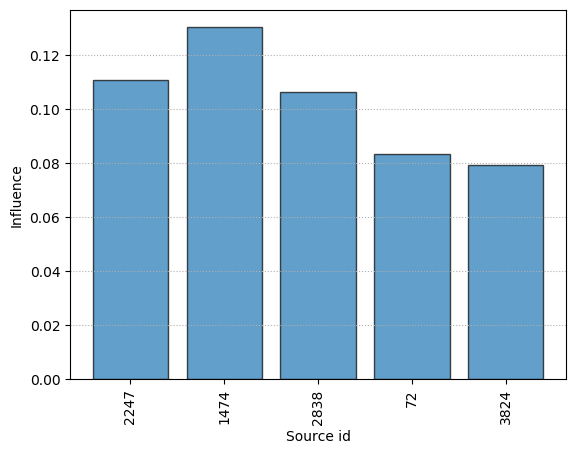

In [25]:
t = sources
bar(1:length(t), [corrupt_score[s] for s in sources],
    capsize=5, linewidth=1, edgecolor="black", alpha=0.7)
xticks(1:length(t), t, rotation = 90)
ylabel("Influence")
xlabel("Source id")
PyPlot.grid(ls=":", axis="y")
# savefig("figs/sources_impact2.pdf", bbox_inches="tight");

Visualising the sources on the graph. Doesn't work very well on bigger graphs. You may need to add extra packages to Julia.

In [31]:
#let's see where the sources are on the graph
# using Cairo, Compose, Colors
# nodefillc = [v in sources ? colorant"orange" : colorant"blue" for v in vertices(g)]
# nodelabels = [v in sources ? v : "" for v in vertices(g)]
# Compose.draw(SVG("figs/sources.svg", 16cm, 16cm), gplot(g, nodefillc=nodefillc, nodelabel=nodelabels));

In [32]:
# open("figs/sources.svg") do f
#    display("image/svg+xml", read(f, String))
# end

## Testing the learning threshold 

In [33]:
LT(p, mu10, mu01, T) = 1/(p^T*(1-mu10-mu01)^(2*T))

LT (generic function with 1 method)

In [34]:
theta = 0.6# prior probability the true state is 1
p = 0.9 # dropout rate
mu10 = 0.1 # mutation from 1 to 0
mu01 = 0.15; # mutation from 0 to 1

In [35]:
t = 500:500:5000
N = 50

diams = Dict(t .=> zeros(length(t)))
learn_probs_log = Dict(t .=> zeros(length(t)))
learn_probs_lin = Dict(t .=> zeros(length(t)))
learn_probs_exact = Dict(t .=> zeros(length(t)))
learn_probs_const = Dict(t .=> zeros(length(t)))


for n in t
    println(n)
    g = watts_strogatz(n, 10, 0.1)
#     diams[n] = diameter(g)
#     c_const = LT(p, mu10, mu01, diams[t[1]])
    c_const = 15
    c_log = c_const/log(t[1])
    c_lin = c_const/t[1]
    
    n_sources = Int(ceil(c_log*log(n)))
    sources = sample(vertices(g), n_sources; replace=false)
    original_msg = Dict(sources .=> ones(Int, length(sources)))
    instance = Grapevine(g, sources, original_msg, mu10, mu01, p, theta)
    data = run_experiment(instance, N)
    learn_probs_log[n] = mean([mean(values(x)) for x in values(data)])
    
    n_sources = Int(ceil(c_lin*n))
    sources = sample(vertices(g), n_sources; replace=false)
    original_msg = Dict(sources .=> ones(Int, length(sources)))
    instance = Grapevine(g, sources, original_msg, mu10, mu01, p, theta)
    data = run_experiment(instance, N)
    learn_probs_lin[n] = mean([mean(values(x)) for x in values(data)])
    
#     n_sources = Int(ceil(LT(p, mu10, mu01, diams[n])))
#     sources = sample(vertices(g), n_sources; replace=false)
#     original_msg = Dict(sources .=> ones(Int, length(sources)))
#     instance = Grapevine(g, sources, original_msg, mu10, mu01, p, theta)
#     data = run_experiment(instance, N)
#     learn_probs_exact[n] = mean([mean(values(x)) for x in values(data)])
    
    n_sources = Int(ceil(c_const))
    sources = sample(vertices(g), n_sources; replace=false)
    original_msg = Dict(sources .=> ones(Int, length(sources)))
    instance = Grapevine(g, sources, original_msg, mu10, mu01, p, theta)
    data = run_experiment(instance, N)
    learn_probs_const[n] = mean([mean(values(x)) for x in values(data)])
    println()
end

500

1000

1500

2000

2500

3000

3500

4000

4500

5000



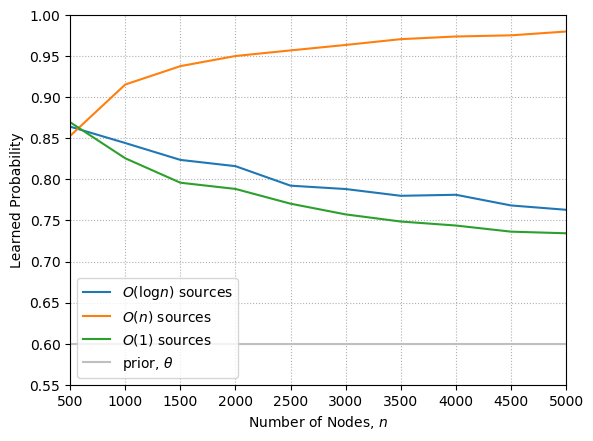

In [35]:
# figure(figsize=[6, 4])
# fig,ax = plt.subplots(figsize=(8, 6))

# title("Watts-Strogatz (n, 10, 0.3)")
PyPlot.grid(ls=":")

plot(t, [learn_probs_log[n] for n in t], label = L"O(\log n)"*" sources")
plot(t, [learn_probs_lin[n] for n in t], label = L"O(n)"*" sources")
# plot(t, [learn_probs_exact[n] for n in t], label = L"\ell(n)"*" sources")
plot(t, [learn_probs_const[n] for n in t], label = L"O(1)"*" sources")


axhline(theta, color="0.75", label="prior, "*L"\theta")
xlabel("Number of Nodes, "*L"n")
ylabel("Learned Probability")

xlim([t[1], t[end]])
ylim([0.55, 1])
# ax2 = ax.twinx()
# ax2.plot(t, 2 .* log.(t), alpha=0.4, ls="--", label=L"2 \log n"*" sources")
# ax2.plot(t, 0.02 .* t, alpha=0.4, ls="--", label=L"0.02n"*" sources")
# ylabel("Number of Sources")

legend()
# subplots_adjust(bottom=0.25)

# savefig("figs/learning_vs_sources.png", bbox_inches="tight")